# Looking at the new CalTopoCluster Derivation

Ana has removed the leading jet CaloTopoCluster cut in the derivation (see [here](https://github.com/gordonwatts/sx_training_fetch/issues/45) for explanation).

Lets compare the two files to see what things look like.

Improvements since last time:

* Good jet cut on kinematics ($p_T>40$ GeV and $\eta<2.5$)
* Quality cut is applied to jets - `LooseBadLLP`

Main Conclusions:

* 2025-04-98
    * There is much less of a problem now - many fewer jets have zero clusters!
    * Some of the data structures that I observe are "odd" and need more examination than I have time for this evening! I'm worried I might have a bug in my data extraction.
* 2025-04-18
    * The newest files with no cluster removal shows - there are no longer missing clusters! So this setting is it! See this [github issue](https://github.com/gordonwatts/sx_training_fetch/issues/45) for more information on what was changed.

## Accessing the Clusters from the Jet Objects

Lets look at the cluster links attached to the jets themselves, especially in in light of the [info from the CaloRing and other people's code](https://codimd.web.cern.ch/C-Be_jRLSZSiydqJR7mr7g).

### Using `constituentLinks`

First, a quick look at the number of clusters attached to each jet

In [1]:
from typing import Tuple

import awkward as ak
import hist
import matplotlib.pyplot as plt
import mplhep
from hist import Hist

from calratio_training_data import (build_preselection, fetch_training_data,
                                    run_query)

We have an old and a new derivation in the local directory here:

In [2]:
ds_old = "../DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root"
ds_new = "../DAOD_LLP1.outputLLP1_mc23_527565_NoLeadingJetsTracksAllPt_09042025.pool.root"

In [3]:
# Turn the data into a list of jets.
full_data_old = fetch_training_data(ds_old)
full_data_new = fetch_training_data(ds_new)

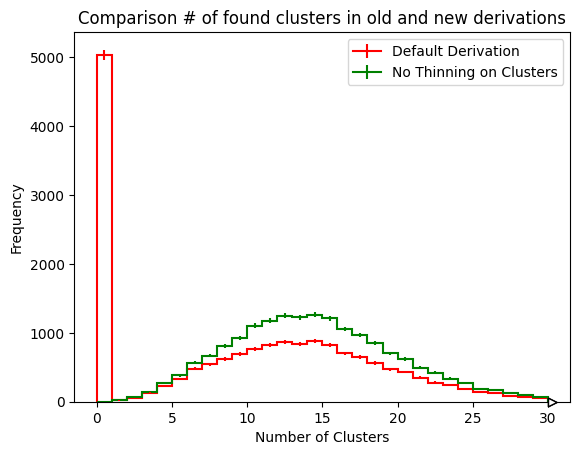

In [4]:
# Create histograms for numbers of clusters for each jet
h_n_found_old = Hist.new.Reg(
    30, 0, 30, name="n_found_clusters_old", label="Number of Found Clusters - Old Dataset"
).Double()
h_n_found_new = Hist.new.Reg(
    30, 0, 30, name="n_found_clusters_new", label="Number of Found Clusters - New Dataset"
).Double()

# Look at only items that have a good jet (this is a servicex bug we need to fix!)
good_jets_old = full_data_old.jet_pt > 0.0
good_jets_new = full_data_new.jet_pt > 0.0

# Fill in with # of clusters.
h_n_found_old.fill(ak.flatten(ak.count(full_data_old.clus_eta[good_jets_old], axis=-1)))
h_n_found_new.fill(ak.flatten(ak.count(full_data_new.clus_eta[good_jets_new], axis=-1)))

# Plot the histograms on the same plot
plt.figure()
mplhep.histplot(h_n_found_old, histtype="step", color="red", label="Default Derivation")
mplhep.histplot(h_n_found_new, histtype="step", color="green", label="No Thinning on Clusters")
plt.title("Comparison # of found clusters in old and new derivations")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Substantial improvement! But what is going on with those zeros that are still there?

## Kinematics of the zeros

In [5]:
def get_cluster_jets(data):
    good_jets = data.jet_pt > 0
    good_jets_with_no_clusters = ak.count(data.clus_eta[good_jets], axis=-1) == 0
    return good_jets_with_no_clusters

jet_zero_mask_old = get_cluster_jets(full_data_old)
jet_zero_mask_new = get_cluster_jets(full_data_new)

/home/gwatts/code/atlas/sx_training_fetch/.venv/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


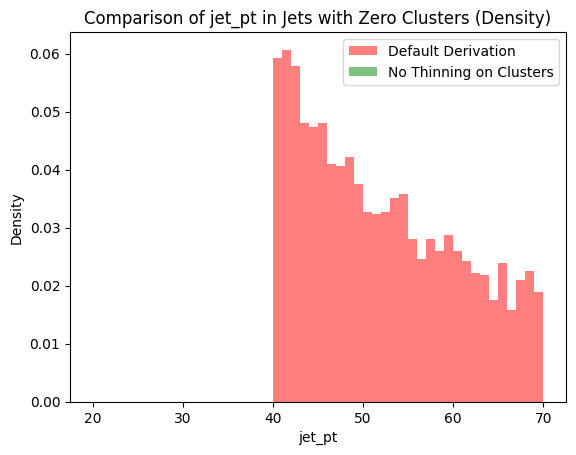

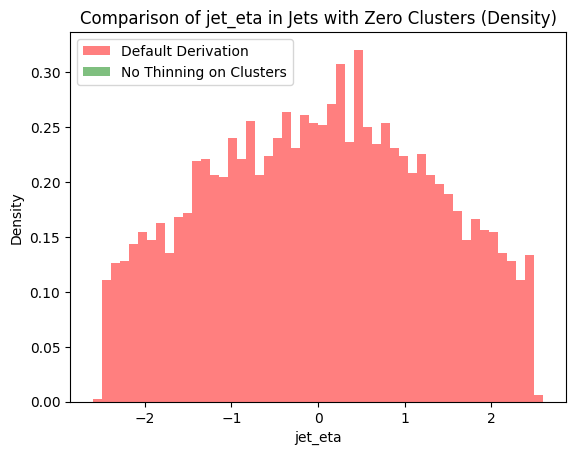

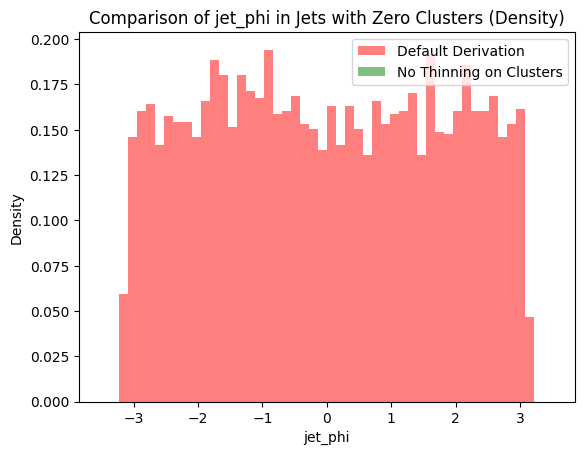

In [6]:
def plot(item: str, range: Tuple[float, float]):
    data_old = ak.flatten(full_data_old[item][jet_zero_mask_old])
    data_new = ak.flatten(full_data_new[item][jet_zero_mask_new])

    plt.figure()
    plt.hist(
        data_old,
        bins=50,
        alpha=0.5,
        label="Default Derivation",
        color="red",
        density=True,
        range=range,
    )
    plt.hist(
        data_new,
        bins=50,
        alpha=0.5,
        label="No Thinning on Clusters",
        color="green",
        density=True,
        range=range,
    )
    plt.title(f"Comparison of {item} in Jets with Zero Clusters (Density)")
    plt.xlabel(item)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot("jet_pt", (20, 70))
plot("jet_eta", (-2.6, 2.6))
plot("jet_phi", (-3.5, 3.5))

Clearly shows that there are no missing clusters - the _no thinning_ histogram is empty!